✅ Data Loaded Successfully
Shape: (6435, 8)
   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  

⚠️ 'Dept' column not found in raw data. A dummy 'Dept' column (value 1) has been created.

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store       

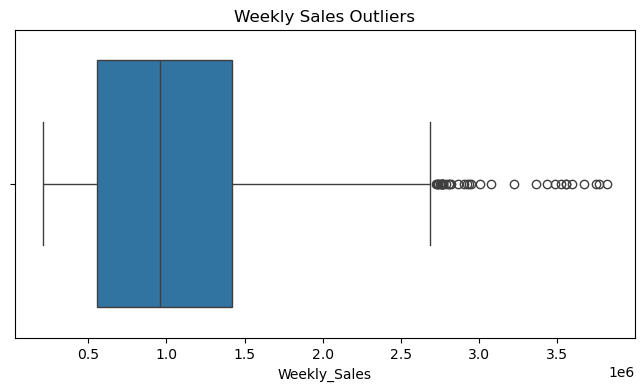

Number of Outliers: 34

Weekly_Sales after capping outliers:
count    6.435000e+03
mean     1.045029e+06
min      2.099862e+05
25%      5.533501e+05
50%      9.607460e+05
75%      1.420159e+06
max      2.720371e+06
std      5.572961e+05
Name: Weekly_Sales, dtype: float64

DataFrame with new features:
   Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1 2010-02-05    1643690.90             0        42.31       2.572   
1      1 2010-02-12    1641957.44             1        38.51       2.548   
2      1 2010-02-19    1611968.17             0        39.93       2.514   
3      1 2010-02-26    1409727.59             0        46.63       2.561   
4      1 2010-03-05    1554806.68             0        46.50       2.625   

          CPI  Unemployment  Dept  Year  ...  Week  Day  day_of_week  \
0  211.096358         8.106     1  2010  ...     5    5            4   
1  211.242170         8.106     1  2010  ...     6   12            4   
2  211.289143         8.1

In [21]:
# ==========================
# 📌 Sales Forecasting Project - Data Preprocessing & Feature Engineering
# ==========================

## 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import os

## 2. Load Raw Dataset
raw_path = "../data/raw/Walmart.csv"
df = pd.read_csv(raw_path)

print("✅ Data Loaded Successfully")
print("Shape:", df.shape)
print(df.head())

if 'Dept' not in df.columns:
    df['Dept'] = 1
    print("\n⚠️ 'Dept' column not found in raw data. A dummy 'Dept' column (value 1) has been created.")

## 3. Basic Info
print("\nBasic Info:")
df.info()
print("\nDescriptive Statistics:")
print(df.describe())

## 4. Convert Date Column & Sort Data
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")
df = df.sort_values(["Store", "Date"]).reset_index(drop=True)

print("\nAfter converting and sorting Date:")
print(df.head())

## 5. Check for Missing Values
print("\nMissing Values per Column:")
print(df.isnull().sum())

## 6. Outlier Detection (Weekly_Sales)
plt.figure(figsize=(8,4))
sns.boxplot(x=df["Weekly_Sales"])
plt.title("Weekly Sales Outliers")
plt.show()

Q1 = df["Weekly_Sales"].quantile(0.25)
Q3 = df["Weekly_Sales"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df["Weekly_Sales"] < lower_bound) | (df["Weekly_Sales"] > upper_bound)]
print("Number of Outliers:", len(outliers))

## 7. Handle Outliers (Cap values)
df["Weekly_Sales"] = np.where(df["Weekly_Sales"] < lower_bound, lower_bound,
                              np.where(df["Weekly_Sales"] > upper_bound, upper_bound,
                                       df["Weekly_Sales"]))
print("\nWeekly_Sales after capping outliers:")
print(df.describe()["Weekly_Sales"])

## 8. Feature Engineering (Temporal & Lag Features)
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
df['Day'] = df['Date'].dt.day
df['day_of_week'] = df['Date'].dt.dayofweek
df['is_weekend'] = df['Date'].dt.dayofweek.isin([5, 6]).astype(int)

# Create Lag Features
df['sales_lag_1'] = df.groupby('Store')['Weekly_Sales'].shift(1)
df['sales_lag_2'] = df.groupby('Store')['Weekly_Sales'].shift(2)
df['sales_lag_4'] = df.groupby('Store')['Weekly_Sales'].shift(4) # New Feature

# Create Rolling Averages & Standard Deviations (aligned with the model's expected names)
df['rolling_mean_4w'] = df.groupby('Store')['Weekly_Sales'].rolling(window=4).mean().reset_index(level=0, drop=True).shift(1)
df['rolling_mean_12w'] = df.groupby('Store')['Weekly_Sales'].rolling(window=12).mean().reset_index(level=0, drop=True).shift(1)
df['rolling_std_4w'] = df.groupby('Store')['Weekly_Sales'].rolling(window=4).std().reset_index(level=0, drop=True).shift(1) # New Feature

df.fillna(0, inplace=True)
print("\nDataFrame with new features:")
print(df.head())

## 9. Scale Numeric Features
scaler = StandardScaler()
num_cols = ["Weekly_Sales", "Temperature", "Fuel_Price", "CPI", "Unemployment", 
            "sales_lag_1", "sales_lag_2", "sales_lag_4", # Updated
            "rolling_mean_4w", "rolling_mean_12w", "rolling_std_4w"] # Updated

df[num_cols] = scaler.fit_transform(df[num_cols])

print("\nDataFrame after scaling:")
print(df.head())

## 10. Save Processed Data
processed_path = "../data/processed/walmart_with_features.csv"
os.makedirs("../data/processed", exist_ok=True)
df.to_csv(processed_path, index=False)

print("\n✅ Processed Data Saved to:", processed_path)

In [8]:
if 'Dept' not in df.columns:
    df['Dept'] = 1 # Assign a default department ID, assuming it's a single department or a placeholder
    print("\n 'Dept' column not found in raw data. A dummy 'Dept' column (value 1) has been created.")
## 4. Convert Date Column & Sort Data
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")
df = df.sort_values(["Store", "Date"]).reset_index(drop=True)

print("\nAfter converting and sorting Date:")
print(df.head())

## 5. Check for Missing Values
print("\nMissing Values per Column:")
print(df.isnull().sum())


 'Dept' column not found in raw data. A dummy 'Dept' column (value 1) has been created.

After converting and sorting Date:
   Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1 2010-02-05      1.074309             0    -0.995136   -1.713800   
1      1 2010-02-12      1.071198             1    -1.201170   -1.766089   
2      1 2010-02-19      1.017382             0    -1.124178   -1.840166   
3      1 2010-02-26      0.654458             0    -0.760907   -1.737766   
4      1 2010-03-05      0.914805             0    -0.767955   -1.598328   

        CPI  Unemployment  Year  Month  Week  Day  day_of_week  is_weekend  \
0  1.004175      0.056964  2010      2     5    5            4           0   
1  1.007880      0.056964  2010      2     6   12            4           0   
2  1.009074      0.056964  2010      2     7   19            4           0   
3  1.009849      0.056964  2010      2     8   26            4           0   
4  1.010624      0.056964  2

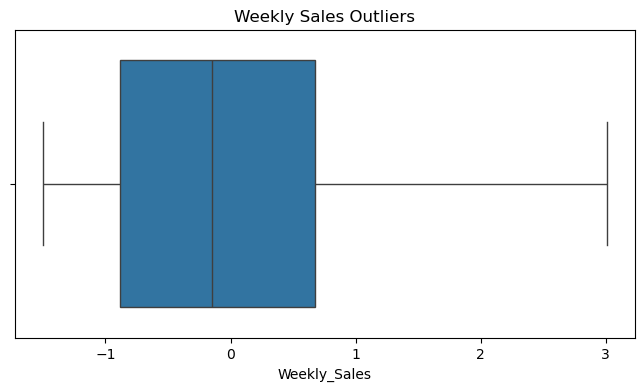

Number of Outliers: 0


In [14]:

## 6. Outlier Detection (Weekly_Sales)
plt.figure(figsize=(8,4))
sns.boxplot(x=df["Weekly_Sales"])
plt.title("Weekly Sales Outliers")
plt.show()

Q1 = df["Weekly_Sales"].quantile(0.25)
Q3 = df["Weekly_Sales"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df["Weekly_Sales"] < lower_bound) | (df["Weekly_Sales"] > upper_bound)]
print("Number of Outliers:", len(outliers))


In [15]:
# ## 5. Check for Missing Values
print("Missing Values per Column:")
print(df.isnull().sum())


Missing Values per Column:
Store               0
Date                0
Weekly_Sales        0
Holiday_Flag        0
Temperature         0
Fuel_Price          0
CPI                 0
Unemployment        0
Dept                0
Year                0
Month               0
Week                0
Day                 0
day_of_week         0
is_weekend          0
sales_lag_1         0
sales_lag_2         0
sales_lag_4         0
rolling_mean_4w     0
rolling_mean_12w    0
rolling_std_4w      0
dtype: int64


In [16]:
## 7. Handle Outliers (Cap values)
df["Weekly_Sales"] = np.where(df["Weekly_Sales"] < lower_bound, lower_bound,
                              np.where(df["Weekly_Sales"] > upper_bound, upper_bound,
                                       df["Weekly_Sales"]))
print("\nWeekly_Sales after capping outliers:")
print(df.describe()["Weekly_Sales"])


Weekly_Sales after capping outliers:
count    6.435000e+03
mean     1.413356e-16
min     -1.498499e+00
25%     -8.823268e-01
50%     -1.512476e-01
75%      6.731764e-01
max      3.006431e+00
std      1.000078e+00
Name: Weekly_Sales, dtype: float64


In [17]:
# ## 7. Handle Outliers (Optional: Cap values)
df["Weekly_Sales"] = np.where(df["Weekly_Sales"] < lower_bound, lower_bound,
                              np.where(df["Weekly_Sales"] > upper_bound, upper_bound,
                                       df["Weekly_Sales"]))


In [18]:
## 8. Feature Engineering (Temporal & Lag Features)
# This is the crucial step to create the features your model expects.
# We'll group by `Store` to create these features correctly for each store.

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
df['Day'] = df['Date'].dt.day
df['day_of_week'] = df['Date'].dt.dayofweek
df['is_weekend'] = df['Date'].dt.dayofweek.isin([5, 6]).astype(int)

# Create Lag Features
df['sales_lag_1'] = df.groupby('Store')['Weekly_Sales'].shift(1)
df['sales_lag_2'] = df.groupby('Store')['Weekly_Sales'].shift(2)

# Create Rolling Averages (aligned with the model's expected names)
df['rolling_mean_4w'] = df.groupby('Store')['Weekly_Sales'].rolling(window=4).mean().reset_index(level=0, drop=True).shift(1)
df['rolling_mean_12w'] = df.groupby('Store')['Weekly_Sales'].rolling(window=12).mean().reset_index(level=0, drop=True).shift(1)

df.fillna(0, inplace=True)
print("\nDataFrame with new features:")
print(df.head())


DataFrame with new features:
   Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1 2010-02-05      1.074309             0    -0.995136   -1.713800   
1      1 2010-02-12      1.071198             1    -1.201170   -1.766089   
2      1 2010-02-19      1.017382             0    -1.124178   -1.840166   
3      1 2010-02-26      0.654458             0    -0.760907   -1.737766   
4      1 2010-03-05      0.914805             0    -0.767955   -1.598328   

        CPI  Unemployment  Dept  Year  ...  Week  Day  day_of_week  \
0  1.004175      0.056964     1  2010  ...     5    5            4   
1  1.007880      0.056964     1  2010  ...     6   12            4   
2  1.009074      0.056964     1  2010  ...     7   19            4   
3  1.009849      0.056964     1  2010  ...     8   26            4   
4  1.010624      0.056964     1  2010  ...     9    5            4   

   is_weekend  sales_lag_1  sales_lag_2  sales_lag_4  rolling_mean_4w  \
0           0     0

In [19]:

## 9. Scale Numeric Features
scaler = StandardScaler()
num_cols = ["Weekly_Sales", "Temperature", "Fuel_Price", "CPI", "Unemployment", 
            "sales_lag_1", "sales_lag_2", "rolling_mean_4w", "rolling_mean_12w"]


df[num_cols] = scaler.fit_transform(df[num_cols])

print("\nDataFrame after scaling:")
print(df.head())


DataFrame after scaling:
   Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1 2010-02-05      1.074309             0    -0.995136   -1.713800   
1      1 2010-02-12      1.071198             1    -1.201170   -1.766089   
2      1 2010-02-19      1.017382             0    -1.124178   -1.840166   
3      1 2010-02-26      0.654458             0    -0.760907   -1.737766   
4      1 2010-03-05      0.914805             0    -0.767955   -1.598328   

        CPI  Unemployment  Dept  Year  ...  Week  Day  day_of_week  \
0  1.004175      0.056964     1  2010  ...     5    5            4   
1  1.007880      0.056964     1  2010  ...     6   12            4   
2  1.009074      0.056964     1  2010  ...     7   19            4   
3  1.009849      0.056964     1  2010  ...     8   26            4   
4  1.010624      0.056964     1  2010  ...     9    5            4   

   is_weekend  sales_lag_1  sales_lag_2  sales_lag_4  rolling_mean_4w  \
0           0    -0.000

In [20]:

## 10. Save Processed Data
processed_path = "../data/processed/walmart_with_features.csv"
os.makedirs("../data/processed", exist_ok=True)
df.to_csv(processed_path, index=False)

print("\n Processed Data Saved to:", processed_path)


 Processed Data Saved to: ../data/processed/walmart_with_features.csv
